<a href="https://colab.research.google.com/github/TheYoungBeast/Data-Augmentation-Keystrokes-Dynamics/blob/main/Data_Augmentation_Keystrokes_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.8.2


In [ ]:
import matplotlib.pyplot as plt
import random as r
import numpy as np
from numpy import array
import math
import copy

<h1>Data Types</h1>


In [ ]:
from typing import NamedTuple

class Set(NamedTuple):
  id: int
  keystrokes: array = []
  aug: bool = False

class Keystroke(NamedTuple):
  key: str
  up: int
  down: int

  def dtime(self): # Dwell Time
    return abs(self.up - self.down)

<h1>Loading dataset</h1>

In [ ]:
Kdataset = {};

def load_dataset(dataset):
  for i in range(1, 15):
    dataset[str(i)] = []

    for j in range(0, 3):
      filepath = "drive/MyDrive/Keystrokes/#" + str(i).zfill(2) + "_" + str(j)  +".txt"
      dataset[str(i)].append(Set(i-1, []))

      with open(filepath, 'r') as f:
              line = f.readline()
              while line:

                if len(line.strip().split(',')) == 3:
                  key, down, up = line.strip().split(',')
                  keystroke = Keystroke(key, abs(int(up)), abs(int(down)))
                  dataset[str(i)][-1].keystrokes.append(keystroke)

                line = f.readline()

load_dataset(Kdataset)

In [ ]:
def split_dataset(dataset):
  """
  Splits dataset to training part and testing part.
  The last sample in class is considered to test data.
  """
  
  train_dataset = {}
  test_dataset = {}

  for key in dataset:
    train_dataset[key] = []
    for index in range(len(dataset[key])-1):
      train_dataset[key].append(dataset[key][index])

    test_dataset[key] = []
    test_dataset[key].append(dataset[key][-1]) # append the last set as training data for a given class
  
  return train_dataset, test_dataset

In [ ]:
train_dataset, test_dataset = split_dataset(Kdataset)

for key in train_dataset:
  assert train_dataset[key] == Kdataset[key][0:2], "Train dataset split corrupted"

for key in test_dataset:
  assert test_dataset[key] == Kdataset[key][-1:], "Test dataset split corrupted"

<h1>Preprocessing and Normalization</h1>

In [ ]:
def preprocess(set):
  """
  set - single Keystroke set from Dataset
  The result of the following procedure is a dictionary of unique Keys (Keystroke.Key)
  which contains the average dwell time for a given key.
  """

  array = []

  for keystroke in set.keystrokes:
    if keystroke.key:
      array.append(keystroke.dtime())
  
  return array, set.id

  dict = {}
  count = {}

  for keystroke in set.keystrokes:
    if not keystroke.key:
      continue

    if keystroke.key not in dict:
      dict[keystroke.key] = 0
      count[keystroke.key] = 0

    dict[keystroke.key] += keystroke.dtime() # Abs, dwell time
    count[keystroke.key] += 1

  # Average dwell time per Key
  avgs = []
  
  for key in dict:
    avgs.append(math.floor(dict[key]/count[key]))

  if len(avgs) is not 27:
    raise Exception('Dataset is corrupted', 'The number of unique keys in the set exceeds 27')

  return avgs, set.id

In [ ]:
def normalize(data):
  """
  Local (within set) normalization.
  Finds max absolute dwell time in a given set,
  then divides all data by that max value.
  """
  
  norm_data = []
  max = np.max([abs(dtime) for dtime in data])

  for i in range(len(data)):
    norm_data.append(data[i] / max) # local normalization

  return norm_data

In [ ]:
def convert_dataset(dataset):
  data = []
  labels = []

  for key in dataset:
    for set in dataset[key]:
      processed_data, sid = preprocess(set)

      data.append(
          normalize(processed_data) # normalization before appending
      )
      labels.append(sid) # append label
  
  return data, labels

In [ ]:
train_data, train_labels = convert_dataset(train_dataset)
test_data, test_labels = convert_dataset(test_dataset)

assert len(test_data) == len(test_labels), 'The size of data is not equal'
assert len(train_data) == len(train_labels), 'The size of data is not equal'

<h3>Example of the processed and normalized vector</h3>

In [ ]:
print(train_data[0])

[0.4460674157303371, 0.07528089887640449, 0.12247191011235956, 0.149438202247191, 0.748314606741573, 0.09550561797752809, 0.27415730337078653, 0.3651685393258427, 0.5651685393258427, 0.09887640449438202, 0.5438202247191011, 0.4651685393258427, 0.37191011235955057, 0.3921348314606742, 0.016853932584269662, 0.4247191011235955, 0.09775280898876404, 0.20898876404494382, 0.36404494382022473, 0.025842696629213482, 0.17640449438202246, 0.06179775280898876, 0.8056179775280898, 0.05955056179775281, 0.09213483146067415, 0.4337078651685393, 0.019101123595505618, 0.298876404494382, 0.1943820224719101, 0.006741573033707865, 0.9247191011235955, 0.46741573033707867, 0.9696629213483146, 0.17752808988764046, 0.451685393258427, 0.401123595505618, 0.4337078651685393, 0.15842696629213482, 0.20337078651685395, 0.23146067415730337, 0.16404494382022472, 0.7337078651685394, 0.16067415730337078, 0.02359550561797753, 0.6, 0.24157303370786518, 0.3044943820224719, 0.501123595505618, 0.1752808988764045, 0.20786516

<h1>Neural Network Model</h1>

In [ ]:
class TrainingGuardCallback(keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    pass

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None:
      if epoch > 200 or logs.get('accuracy') > 0.95:
        self.model.stop_training = True
        print("\nTraining goals met. Training has been stopped!!")   

In [ ]:
class SaveBestModel(keras.callbacks.Callback):

  def __init__(self, metric='accuracy'):
    self.metric = metric
    self.best = 0.0

  def on_train_batch_end(self, batch, logs=None):
    pass

  def on_epoch_end(self, epoch, logs={}):
    value = logs[self.metric]

    if value:
      if value > self.best and epoch > 20:
        self.best = value
        self.weights = self.model.get_weights()
        self.logs = logs
        #print("\n")
        #print("Saving model weights. The best {} value detected so far ({:.2f}%)".format(self.metric, value*100))

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = np.shape(train_data[0])))
model.add(keras.layers.Dropout(0.2) ) # helps prevent overfitting
model.add(keras.layers.Dense(1024, activation=keras.activations.relu)) # 1st hidden layer
model.add(keras.layers.Dropout(0.5) ) # helps prevent overfitting
model.add(keras.layers.Dense(2048, activation=keras.activations.relu)) # 2nd hidden layer
model.add(keras.layers.Dense(14, activation=keras.activations.softmax)) # output layer

In [ ]:
model.compile(                                          # use adam optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'], 
    loss=keras.losses.SparseCategoricalCrossentropy()   # labels provided as integers, for one-hot vectors use keras.losses.CategoricalCrossentropy
    )

In [ ]:
BestModelCallback = SaveBestModel(metric='val_accuracy') # callback, save weights when the model hits the best value for a given metric

history = model.fit(train_data, train_labels, verbose=0, epochs=100, validation_data=(test_data, test_labels), callbacks=[BestModelCallback]) # train the model

model.set_weights(BestModelCallback.weights) # load saved model weights

In [ ]:
print("NN accuracy: {:.2f}% \t loss: {:.5f}".format(BestModelCallback.logs['accuracy']*100, BestModelCallback.logs['loss']))

NN accuracy: 100.00% 	 loss: 0.94640


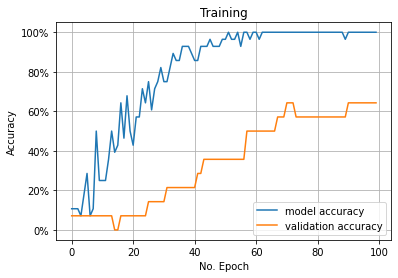

In [ ]:
thist = history.history
plt.title("Training")
plt.plot([el * 100 for el in thist['accuracy']], label="model accuracy")
plt.plot([el * 100 for el in thist['val_accuracy']], label="validation accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.xlabel("No. Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

<h1>Testing the model</h1>

In [ ]:
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print("Model loss (test data): {:.3f} \nModel accuracy (test data): {:.2f}%".format(loss, accuracy*100))

Model loss (test data): 2.125 
Model accuracy (test data): 64.29%


<h1>Data augmentation</h1>


In [ ]:
class Augmenter():
  def __init__(self):
      pass

  def set_keystroke_set(self, set):
    self.set = copy.deepcopy(set)
    self.set = self.set._replace(aug=True)

    return self

  def get_augmented_set(self):
    return self.set

  def avg_and_gauss(self, dataset, mu=5, sigma=5):

    avgUp = np.zeros((len(self.set.keystrokes),)) # avg Up time for every keystroke in dataset
    avgDown = np.zeros((len(self.set.keystrokes),)) # avg Down time for every keystroke in dataset

    for kSet in dataset[str(self.set.id+1)]:
      for i in range(len(kSet.keystrokes)):
        avgUp[i] = avgUp[i] + kSet.keystrokes[i].up
        avgDown[i] = avgDown[i] + kSet.keystrokes[i].down

    assert len(avgUp) == len(avgDown)

    no_of_sets = len(dataset[str(self.set.id+1)])
    for i in range(len(avgUp)):
      avgUp[i] = avgUp[i] / no_of_sets
      avgDown[i] = avgDown[i] / no_of_sets

    dst = np.random.normal(mu, sigma, len(avgUp))
    
    for i in range(len(self.set.keystrokes)):
      self.set.keystrokes[i] = Keystroke(self.set.keystrokes[i].key, 
                                math.ceil(avgUp[i] + dst[i]),
                                math.ceil(avgDown[i] + dst[i]))
    
    return self

  def random_replace(self, rate=10):
    
    next = rate
    for i in range(len(self.set.keystrokes)):
      if i == next:
        index = i - math.ceil(r.random() * next)
        index = 0 if index < 0 else index
        sub = self.set.keystrokes[index]

        keystroke = Keystroke(self.set.keystrokes[i].key, sub.up, sub.down)
        keystrokeSub = Keystroke(sub.key, self.set.keystrokes[i].up, self.set.keystrokes[i].down)

        self.set.keystrokes[index] = keystrokeSub
        self.set.keystrokes[i] = keystroke
        
        next += rate
    
    return self
  
  def random(self, max = 50, offset = 25):

    for i in range(0, len(self.set.keystrokes)):
      r1 = math.floor((r.random() * max) - offset)
      r2 = math.floor((r.random() * max) - offset)

      keystroke = Keystroke(self.set.keystrokes[i].key, 
                            abs(math.floor(self.set.keystrokes[i].up + r1)),
                            abs(math.floor(self.set.keystrokes[i].down + r2)))
      
      self.set.keystrokes[i] = keystroke
    
    return self

<h1>Testing the result</h1>

In [ ]:
class Benchmark():
  def __init__(self, title, model, dataset, test_dataset, extended_dataset=None):
    self.title = title
    self.model_weights = model.get_weights()
    self.results = {}
    self.dataset = copy.deepcopy(dataset)
    self.extended = extended_dataset

    train_data, train_labels = convert_dataset(dataset)
    self.test_data, self.test_labels = convert_dataset(test_dataset)
    
    loss, accuracy = model.evaluate(self.test_data, self.test_labels, verbose=0)
    self.results[str(len(train_labels))] = accuracy * 100

  def run(self, aug_method, metric='val_accuracy', cycles = 3, epochs=100, mu = 5, sigma = 5, rand_max = 50, rand_offset = 25):
    avg_std = True
    random = False
    dataset_ext = self.dataset

    if aug_method == 'avg_std':
      pass
    elif aug_method == 'avg_std_rand':
      random = True
    elif aug_method == 'random':
      random = True
      avg_std = False
    elif 'avg_std_ext':
      dataset_ext = self.extended
    elif 'avg_std_rand_ext':
      dataset_ext = self.extended
      random = True
    elif 'random_ext':
      random=True
      dataset_ext = self.extended
    else:
      raise Exception("Incorrect augmentation method")

    if dataset_ext is None:
      raise Exception("The extended dataset is None")

    for i in range(cycles):
      train_data, train_labels = self.__augment__(dataset_ext, mu, sigma, rand_max, rand_offset, avg_std, random)

      model.set_weights(self.model_weights) # load defualt weights before every run

      checkpoint = SaveBestModel(metric=metric)
      model.fit(train_data, train_labels, verbose=0, epochs=epochs, shuffle=True, validation_data=(self.test_data, self.test_labels), callbacks=[checkpoint])
      model.set_weights(checkpoint.weights)

      loss, accuracy = model.evaluate(self.test_data, self.test_labels, verbose=0)
      self.results[str(len(train_data))] = accuracy * 100

    model.set_weights(self.model_weights) # set model previous weights after completing the benchmark
    #return self

  def get_title(self):
    return self.title

  def get_results(self):
    return self.results

  def __augment__(self, dataset_ext, mu, sigma, rand_max, rand_offset, avg_std=True, random=False):
    for key in self.dataset:
      if avg_std:
        Aug = Augmenter().set_keystroke_set(self.dataset[key][0]).avg_and_gauss(dataset_ext, mu, sigma)

        if random:
          Aug.random(rand_max, rand_offset)

        self.dataset[key].insert(0, Aug.get_augmented_set()) # prepend
      else:
        for i in range(len(dataset_ext[key])):
          aug_set = Augmenter().set_keystroke_set(dataset_ext[key][i]).random().get_augmented_set()

          self.dataset[key].insert(0, aug_set) # prepend
      
    train_data, train_labels = convert_dataset(self.dataset)

    return train_data, train_labels

In [ ]:
benchmark1 = Benchmark("Avg-based Method with Gaussian noise (train data only)", model, train_dataset, test_dataset)
benchmark1.run(aug_method='avg_std', cycles=5)

rand_max = 50; rand_offset=25
benchmark2 = Benchmark("Avg-based Method with Gaussian noise and random [{}, {}] (train data only)".format(0-rand_offset, rand_max-rand_offset), model, train_dataset, test_dataset)
benchmark2.run(aug_method='avg_std_rand', rand_max=rand_max, rand_offset=rand_offset, cycles=5)

rand_max = 100; rand_offset=50
benchmark3 = Benchmark("Avg-based Method with Gaussian noise and random [{}, {}] (train data only)".format(0-rand_offset, rand_max-rand_offset), model, train_dataset, test_dataset)
benchmark3.run(aug_method='avg_std_rand', rand_max=rand_max, rand_offset=rand_offset, cycles=5)

benchmark4 = Benchmark('Avg-based Method with Gaussian noise (test data included)',  model, train_dataset, test_dataset, Kdataset)
benchmark4.run(aug_method='avg_std_ext', cycles=5)

rand_max = 50; rand_offset=25
benchmark5 = Benchmark('Avg-based Method with Gaussian noise and random [{}, {}] (test data included)'.format(0-rand_offset, rand_max-rand_offset), model, train_dataset, test_dataset, Kdataset)
benchmark5.run(aug_method='avg_std_rand_ext', cycles=5)

rand_max = 100; rand_offset=50
benchmark6 = Benchmark('Avg-based Method with Gaussian noise and random [{}, {}] (test data included)'.format(0-rand_offset, rand_max-rand_offset), model, train_dataset, test_dataset, Kdataset)
benchmark6.run(aug_method='random_ext', rand_max=rand_max, rand_offset=rand_offset, cycles=5)

In [ ]:
def plot_bar(plt, title, stats): 
  plt.set_title(title)

  for key in stats:
    if stats[key] > stats[str(len(train_data))]: plt.bar(key, stats[key], color='lightgreen')
    elif key != str(len(train_data)): color = plt.bar(key, stats[key], color='orange')
    else: plt.bar(key, stats[key], color=[0.5, 0.5, 1, 1])

  plt.bar([0], [0], color='lightgreen', label="Enchanced")
  plt.bar([0], [0], color='orange', label="Underperforming")
  plt.bar([0], [0], color=[0.5, 0.5, 1, 1], label="Base")

  plt.set_yticks(np.arange(0, 101, 10))
  plt.set_yticklabels(['{:.0f}%'.format(x) for x in plt.get_yticks()])
  plt.set_xlabel("Dataset Size (number of total sets)")
  plt.set_ylabel("Test Accuracy")
  plt.legend(loc='lower right')
  plt.grid(color='black', linestyle='dashed', axis='y')

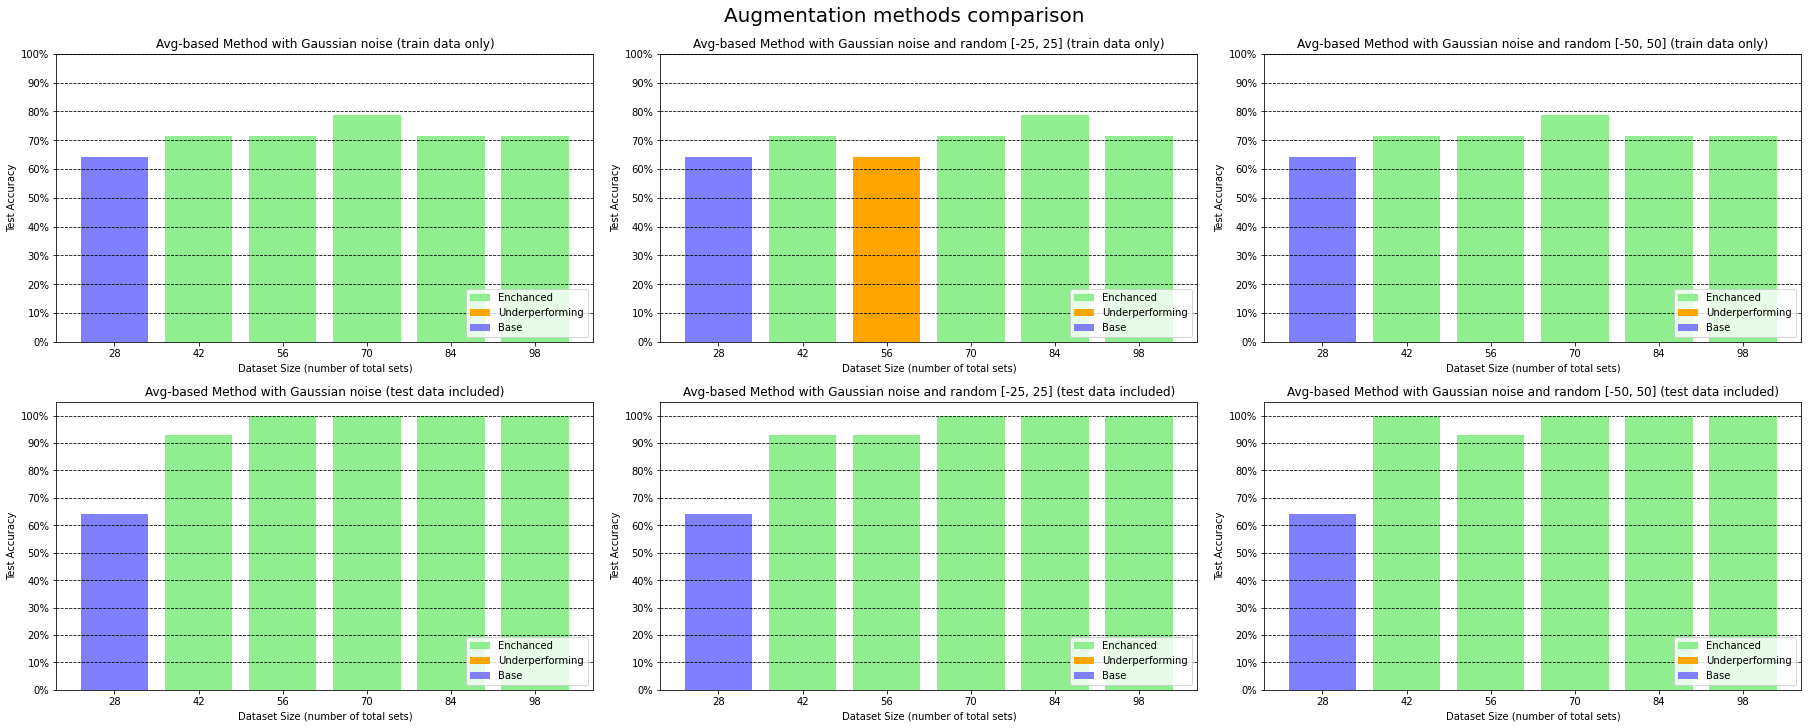

In [ ]:
fig, ax = plt.subplots(2, 3, constrained_layout = True)
fig.set_figheight(10)
fig.set_figwidth(25) 

plot_bar(ax[0, 0], benchmark1.get_title(), benchmark1.get_results())
plot_bar(ax[0, 1], benchmark2.get_title(), benchmark2.get_results())
plot_bar(ax[0, 2], benchmark3.get_title(), benchmark3.get_results())
plot_bar(ax[1, 0], benchmark4.get_title(), benchmark4.get_results())
plot_bar(ax[1, 1], benchmark5.get_title(), benchmark5.get_results())
plot_bar(ax[1, 2], benchmark6.get_title(), benchmark6.get_results())

fig.suptitle('Augmentation methods comparison', size=20)
plt.show()

<h1>Save augmented sets</h1>

In [ ]:
import os

def save_aug_sets(dataset, path, offset):
  os.makedirs(path, exist_ok=True) # create dir if not exists

  for key in dataset:
    sampleid = offset

    for set in dataset[key]:
      if set.aug is not True:
        continue

      filepath = path + "/#" + str(set.id+1).zfill(2) + "_" + str(sampleid)  + ".txt"
      sampleid += 1
      
      with open(filepath, 'w') as f:

        for k in set.keystrokes:
          f.write("\t{}, \t{}, \t{}".format(k.key, k.down, k.up))
          f.write('\n')

In [ ]:
#save_aug_sets(dataset, "drive/MyDrive/Keystrokes/Augmented", 3)